# Raw data for curriculum learning
We may need to give the neural networks an approachable path to understanding Gomoku


Here's the question: Is it possible to train the network such that it can safely detect any open-ended 4 - i.e. a MUST-DEFEND position? Nothing but that.

Note that a single line of 4 is relevant, every other stone is just noise. That must feel like looking for the needle in the haystack. Poor neural network!

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import random
import numpy as np
import tensorflow as tf

from aegomoku.gomoku_game import GomokuGame
from aegomoku.gomoku_board import GomokuBoard
from aegomoku.policies.primary_detector import PrimaryDetector
from aegomoku.gomoku_game import RandomBoardInitializer
from aegomoku.policies.heuristic_policy import HeuristicPolicy
tf.config.list_physical_devices('GPU')
tight = HeuristicPolicy(15, .9)
loose = HeuristicPolicy(15, .3)

2022-08-17 22:19:42.020982: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
/Users/wgiersche/.local/share/virtualenvs/DeepGomoku-cXtJ_EtM/lib/python3.10/site-packages/numpy/core/fromnumeric.py:2009: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = asarray(a).shape


In [3]:
BOARD_SIZE=15
rbi = RandomBoardInitializer(BOARD_SIZE, 4, 5, 9, 5, 9)
game = GomokuGame(BOARD_SIZE, initializer=rbi)

In [4]:
primary = PrimaryDetector(BOARD_SIZE)
def must_defend(the_board):
    current = primary.call(the_board.canonical_representation())[:, :, :, 4]
    return np.max(current, axis=None) >= 333

In [5]:
data = []
def create_sample(the_board: GomokuBoard):
    position = [stone.i for stone in the_board.stones]
    p, v = tight.predict(the_board.canonical_representation())
    probs = (np.array(p)*255).astype(np.uint8)
    v = v.numpy()
    return position, probs, v

In [6]:
def one_game(verbose=False):
    board = game.get_initial_board()
    players = [tight, loose]
    pointer = 0
    s = board.canonical_representation()
    N = 80
    n = 0
    while tight.get_winner(s) is None and n < N:
        player = players[pointer]
        pointer = 1 - pointer
        n += 1
        options = player.get_advisable_actions(board.canonical_representation())
        move = random.choice(options)
        board.act(move)
        s = board.canonical_representation()
        #    options = heuristic.get_advisable_actions(s)
        #    print()
        #    print([board.stone(o) for o in options])
        if tight.get_winner(s) is not None:
            break
        if must_defend(board):
            # print([stone.i for stone in board.stones])
            data.append(create_sample(board))
            if verbose:
                board.plot()
                print("MUST DEFEND")
    if n < N:
        if verbose:
            print([stone.i for stone in board.stones])
            print("GAME OVER")

In [7]:
for i in range(5):
    one_game()

In [8]:
len(data)

26

In [126]:
from pickle import Pickler

with open("rawdata.pickle", 'wb+') as f:
    Pickler(f).dump(data)

In [12]:
!ls -l rawdata.pickle
!pwd

-rw-rw-r-- 1 wgiersche wgiersche 871773 Aug  7 15:06 rawdata.pickle
/home/wgiersche/workspace/Project-Ellie/DeepGomoku/notebooks


# Now try if we can train

In [9]:
from aegomoku.game_data import read_training_data

BOARD_SIZE=15
filename = "rawdata.pickle"
examples = read_training_data(filename, BOARD_SIZE)
len(examples), len(examples[0]), examples[0][0].shape

(20320, 3, (17, 17, 3))

Next to play: WHITE
Value from WHITE's point of view: -0.6030381708362772


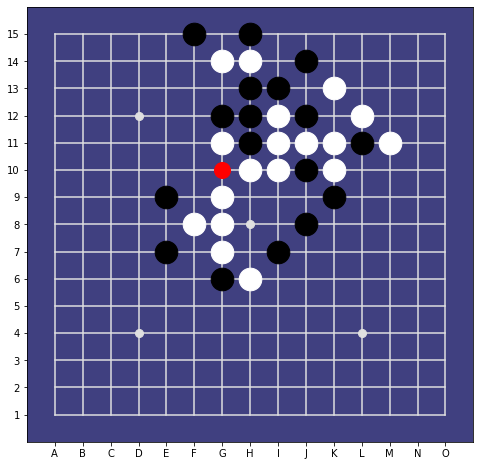

In [5]:
from aegomoku.utils import analyse_example

analyse_example(BOARD_SIZE, examples[random.randint(0, len(examples))])

# Trying various architectures

Here's the point where we will need to look into different architectures

A suitable candidate should (in that order)
- easily overfit a small number of examples
- remain convergent for growing number of examples
- eventually generalize to unseen examples

In [8]:
from aegomoku.gomoku_model import NeuralNetAdapter

the_model = NeuralNetAdapter(BOARD_SIZE + 2)
the_model.policy.compile()

In [9]:
N=50
the_model.train(examples[:N], epochs_per_train=1000, report_every=100)

Epoch: 1, Training: 5.987297058105469, Test: 0.0
Epoch: 101, Training: 5.379342555999756, Test: 0.0
Epoch: 201, Training: 5.346553802490234, Test: 0.0
Epoch: 301, Training: 5.335482597351074, Test: 0.0
Epoch: 401, Training: 5.329912185668945, Test: 0.0
Epoch: 501, Training: 5.32656717300415, Test: 0.0
Epoch: 601, Training: 5.324337959289551, Test: 0.0
Epoch: 701, Training: 5.322741508483887, Test: 0.0
Epoch: 801, Training: 5.321686744689941, Test: 0.0
Epoch: 901, Training: 5.3207621574401855, Test: 0.0
Epochs: 1000, Loss: 5.320000648498535, 


(1, 17, 17, 3)
n=79
Next to play: WHITE
Value from WHITE's point of view: -0.5832451270483647
value = -0.5832451270483647
Next to play: WHITE
Value from WHITE's point of view: [[-0.5864592]]
value = [[-0.5864592]]


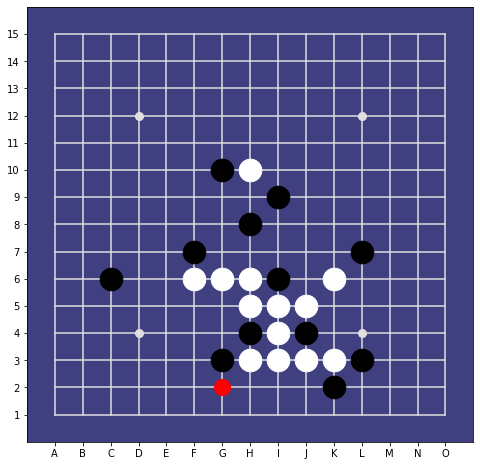

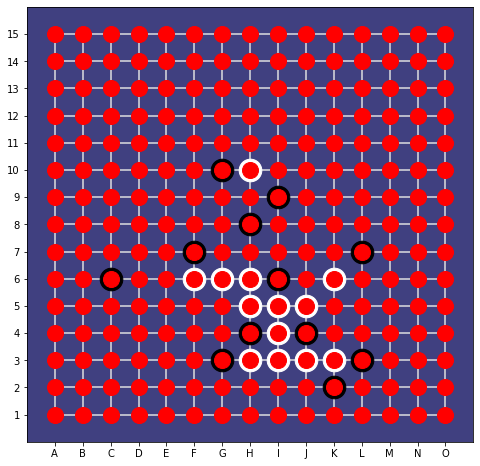

In [10]:
n = random.randint(0, 2*N)
sample = np.expand_dims(examples[n][0], axis=0).astype(float)
print(sample.shape)
p_, v_ = the_model.policy(sample)
s, p, v = examples[n]
example = (s, list(p_.numpy()), v_)
print(f"n={n}")
analyse_example(BOARD_SIZE, examples[n])
print(f"value = {v}")
analyse_example(BOARD_SIZE, example)
print(f"value = {v_}")